In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.feature_extraction import DictVectorizer, text
from sklearn import preprocessing
from LabelEncoder import LabelEncoder
from collections import defaultdict
from sklearn.metrics import classification_report, fbeta_score, roc_auc_score, plot_roc_curve, roc_curve
import lightgbm
from sklearn.model_selection import train_test_split, cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, pyll
pd.options.display.max_columns = 200

In [2]:
data = pd.read_csv('train.csv')
list(data.columns)

/Users/maconline/anaconda3/envs/conda-thrive-prod/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['id',
 'label',
 'Field_1',
 'Field_2',
 'Field_3',
 'Field_4',
 'Field_5',
 'Field_6',
 'Field_7',
 'Field_8',
 'Field_9',
 'Field_10',
 'Field_11',
 'Field_12',
 'Field_13',
 'Field_14',
 'Field_15',
 'Field_16',
 'Field_17',
 'Field_18',
 'Field_19',
 'Field_20',
 'Field_21',
 'Field_22',
 'Field_23',
 'Field_24',
 'Field_25',
 'Field_26',
 'Field_27',
 'Field_28',
 'Field_29',
 'Field_30',
 'Field_31',
 'Field_32',
 'Field_33',
 'Field_34',
 'Field_35',
 'ngaySinh',
 'namSinh',
 'gioiTinh',
 'diaChi',
 'Field_36',
 'Field_37',
 'Field_38',
 'Field_39',
 'Field_40',
 'Field_41',
 'Field_42',
 'Field_43',
 'Field_44',
 'Field_45',
 'Field_46',
 'Field_47',
 'Field_48',
 'Field_49',
 'Field_50',
 'Field_51',
 'Field_52',
 'Field_53',
 'Field_54',
 'Field_55',
 'Field_56',
 'Field_57',
 'Field_58',
 'Field_59',
 'Field_60',
 'Field_61',
 'Field_62',
 'Field_63',
 'Field_64',
 'Field_65',
 'Field_66',
 'Field_67',
 'Field_68',
 'maCv',
 'Field_69',
 'Field_70',
 'Field_71',
 'Field_72'

In [13]:
# field_txt =  ["Field_{}".format(i) for i in [4, 18, 36, 45, 46, 47, 48, 49, 54, 55, 56, 61, 62, 65, 66]]
partners = ['F_numOrg', 'F_numQuery', 'E_numOrg', 'E_numQuery', 'C_numOrg', 'C_numQuery', 'G_numOrg','G_numQuery', 'A_numOrg', 'A_numQuery',
 'partner0_A', 'partner0_B', 'partner0_C', 'partner0_D', 'partner0_E', 'partner0_F', 'partner0_G', 'partner0_H', 'partner0_K', 'partner0_L',
 'partner1_A', 'partner1_B', 'partner1_C', 'partner1_D', 'partner1_E', 'partner1_F', 'partner1_G', 'partner1_H', 'partner1_K', 'partner1_L',
 'partner2_A', 'partner2_B', 'partner2_C', 'partner2_D', 'partner2_E', 'partner2_F', 'partner2_G', 'partner2_H', 'partner2_K', 'partner2_L',
 'partner3_A', 'partner3_B', 'partner3_C', 'partner3_D', 'partner3_E', 'partner3_F', 'partner3_G', 'partner3_H', 'partner3_K', 'partner3_L',
 'partner4_A', 'partner4_B', 'partner4_C', 'partner4_D', 'partner4_E', 'partner4_F', 'partner4_G', 'partner4_H', 'partner4_K', 'partner4_L',
 'partner5_A', 'partner5_B', 'partner5_C', 'partner5_D', 'partner5_E', 'partner5_F', 'partner5_G', 'partner5_H', 'partner5_K', 'partner5_L'
]
number_features = ['age', 'num_of_phone', 'friendCount', 'topFriends', 'subscriberCount', 'numOrg']
text_features = ['currentLocationCity', 'currentLocationCountry', 'currentLocationState',
                 'homeTownCity', 'homeTownCountry', 'homeTownState', 'maCv', 'gioiTinh']
field_txt =  ["Field_{}".format(i) for i in [4, 36, 47, 54, 55, 61, 62, 65, 66]]
field_num = ["Field_{}".format(i) for i in [3, 10, 13, 19, 20, 21, 22, 23, 27, 28, 29, 39, 41, 53, 58, 59, 60, 63, 64, 69, 70, 71, 72, 73, 74, 75, 76,
             77, 78, 79, 80, 81, 82]] + ['summary_6m', 'summary_3m', 'summary_1m', 'summary_1w',] + partners

In [14]:
def get_age(birthday):
    try:
        birth_year = int(str(birthday)[:4])
        return 2020 - birth_year
    except:
        return np.nan
data['age'] = data["ngaySinh"].apply(get_age)
data['age']

0        29.0
1         NaN
2        22.0
3         NaN
4         NaN
         ... 
53025    32.0
53026     NaN
53027    32.0
53028     NaN
53029     NaN
Name: age, Length: 53030, dtype: float64

In [15]:
train_field_num = data[field_num + number_features]
train_field_num = train_field_num.fillna(-1)
train_field_num

,Field_3,Field_10,Field_13,Field_19,Field_20,Field_21,Field_22,Field_23,Field_27,Field_28,Field_29,Field_39,Field_41,Field_53,Field_58,Field_59,Field_60,Field_63,Field_64,Field_69,Field_70,Field_71,Field_72,Field_73,Field_74,Field_75,Field_76,Field_77,Field_78,Field_79,Field_80,Field_81,Field_82,summary_6m,summary_3m,summary_1m,summary_1w,F_numOrg,F_numQuery,E_numOrg,E_numQuery,C_numOrg,C_numQuery,G_numOrg,G_numQuery,A_numOrg,A_numQuery,partner0_A,partner0_B,partner0_C,partner0_D,partner0_E,partner0_F,partner0_G,partner0_H,partner0_K,partner0_L,partner1_A,partner1_B,partner1_C,partner1_D,partner1_E,partner1_F,partner1_G,partner1_H,partner1_K,partner1_L,partner2_A,partner2_B,partner2_C,partner2_D,partner2_E,partner2_F,partner2_G,partner2_H,partner2_K,partner2_L,partner3_A,partner3_B,partner3_C,partner3_D,partner3_E,partner3_F,partner3_G,partner3_H,partner3_K,partner3_L,partner4_A,partner4_B,partner4_C,partner4_D,partner4_E,partner4_F,partner4_G,partner4_H,partner4_K,partner4_L,partner5_A,partner5_B,partner5_C,partner5_D,partner5_E,partner5_F,partner5_G,partner5_H,partner5_K,partner5_L,age,num_of_phone,friendCount,topFriends,subscriberCount,numOrg
0,1.0,1.0,1.0,0.0,4258600.0,4.5,1.0,16.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,3.0,2.0,1.0,0.00,0.49,0.245,0.49,-1.0,-1.0,5.0,0.0,2.0,-1.0,-1.000000,-1.000000,-1.0,1,2.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,1.0,-1.0,-1.0,-1.0,5.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.000,-1.00,1.0,704.0,6.0,2.0,2.0,-1.0,-1.000000,-1.000000,-1.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0
2,2.0,1.0,1.0,0.0,5000000.0,4.5,1.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,3.0,3.0,2.0,0.58,0.77,0.675,0.19,1.0,1076.0,2.0,0.0,2.0,33.0,10.769445,6.466667,0.0,2,7.0,7.0,2.0,1.0,1.0,1.0,2.0,3.0,-1.0,-1.0,-1.0,-1.0,3.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,1.0,-1.0,-1.0,-1.0,5.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.000,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,33.0,10.769445,6.466667,0.0,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.000,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,33.0,10.769445,6.466667,0.0,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [17]:
train_field_txt = data[field_txt + text_features]
train_field_txt = train_field_txt.fillna("")
train_field_txt

,Field_4,Field_36,Field_47,Field_54,Field_55,Field_61,Field_62,Field_65,Field_66,currentLocationCity,currentLocationCountry,currentLocationState,homeTownCity,homeTownCountry,homeTownState,maCv,gioiTinh
0,GH,DN,Four,VN,TF,Khối DN Ngoài quốc doanh,I,Vùng 1,G,,,,,,,Nhân viên bán hàng trực tiếp,MALE
1,,,,,,,,,,,,,,,,,
2,T1,DN,Zezo,,TB,Khối DN Ngoài quốc doanh,I,Vùng 2,E,,,,,,,,FEMALE
3,,,,,,,,,,,,,,,,,
4,,,,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53025,GH,HC,One,VN,SF,"Khối HS, Đảng, Đoàn",I,Vùng 1,D,,,,,,,Bảo mẩu,FEMALE
53026,,,,,,,,,,,,,,,,,
53027,T1,DN,One,NU,YN,Khối DN có vốn DTNN,I,Vùng 1,G,Ho Chi Minh City,Vietnam,Ho Chi Minh City,Ho Chi Minh City,Vietnam,Ho Chi Minh City,Công nhân,FEMALE
53028,,,,,,,,,,,,,,,,,


In [18]:
encoder_dict = defaultdict(LabelEncoder)
train_field_txt = train_field_txt.apply(lambda x: encoder_dict_field_txt[x.name].fit_transform(x))
train_field_txt

,Field_4,Field_36,Field_47,Field_54,Field_55,Field_61,Field_62,Field_65,Field_66,currentLocationCity,currentLocationCountry,currentLocationState,homeTownCity,homeTownCountry,homeTownState,maCv,gioiTinh
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1
2,2,0,2,1,2,0,0,2,2,0,0,0,0,0,0,1,2
3,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1
4,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53025,0,8,3,0,196,7,0,0,3,0,0,0,0,0,0,3589,2
53026,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1
53027,2,0,3,33,11,5,0,0,0,1,1,1,3,1,3,39,2
53028,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1


In [19]:
X = pd.concat([train_field_num, train_field_txt], axis=1)
features = X.columns
X

,Field_3,Field_10,Field_13,Field_19,Field_20,Field_21,Field_22,Field_23,Field_27,Field_28,Field_29,Field_39,Field_41,Field_53,Field_58,Field_59,Field_60,Field_63,Field_64,Field_69,Field_70,Field_71,Field_72,Field_73,Field_74,Field_75,Field_76,Field_77,Field_78,Field_79,Field_80,Field_81,Field_82,summary_6m,summary_3m,summary_1m,summary_1w,F_numOrg,F_numQuery,E_numOrg,E_numQuery,C_numOrg,C_numQuery,G_numOrg,G_numQuery,A_numOrg,A_numQuery,partner0_A,partner0_B,partner0_C,partner0_D,partner0_E,partner0_F,partner0_G,partner0_H,partner0_K,partner0_L,partner1_A,partner1_B,partner1_C,partner1_D,partner1_E,partner1_F,partner1_G,partner1_H,partner1_K,partner1_L,partner2_A,partner2_B,partner2_C,partner2_D,partner2_E,partner2_F,partner2_G,partner2_H,partner2_K,partner2_L,partner3_A,partner3_B,partner3_C,partner3_D,partner3_E,partner3_F,partner3_G,partner3_H,partner3_K,partner3_L,partner4_A,partner4_B,partner4_C,partner4_D,partner4_E,partner4_F,partner4_G,partner4_H,partner4_K,partner4_L,partner5_A,partner5_B,partner5_C,partner5_D,partner5_E,partner5_F,partner5_G,partner5_H,partner5_K,partner5_L,age,num_of_phone,friendCount,topFriends,subscriberCount,numOrg,Field_4,Field_36,Field_47,Field_54,Field_55,Field_61,Field_62,Field_65,Field_66,currentLocationCity,currentLocationCountry,currentLocationState,homeTownCity,homeTownCountry,homeTownState,maCv,gioiTinh
0,1.0,1.0,1.0,0.0,4258600.0,4.5,1.0,16.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,3.0,2.0,1.0,0.00,0.49,0.245,0.49,-1.0,-1.0,5.0,0.0,2.0,-1.0,-1.000000,-1.000000,-1.0,1,2.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,1.0,-1.0,-1.0,-1.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.000,-1.00,1.0,704.0,6.0,2.0,2.0,-1.0,-1.000000,-1.000000,-1.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1
2,2.0,1.0,1.0,0.0,5000000.0,4.5,1.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,3.0,3.0,2.0,0.58,0.77,0.675,0.19,1.0,1076.0,2.0,0.0,2.0,33.0,10.769445,6.466667,0.0,2,7.0,7.0,2.0,1.0,1.0,1.0,2.0,3.0,-1.0,-1.0,-1.0,-1.0,3.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,1.0,-1.0,-1.0,-1.0,5.0,2,0,2,1,2,0,0,2,2,0,0,0,0,0,0,1,2
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.000,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,33.0,10.769445,6.466667,0.0,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.000,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,33.0,10.769445,6.466667,0.0,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.

In [20]:
y = data['label']
print(y.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

0    36234
1    16796
Name: label, dtype: int64


In [21]:
def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    print(X_train.shape, y_train.shape)
    
    def objective_function(params):
        clf = lightgbm.LGBMClassifier(**params)
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    clf_best = lightgbm.LGBMClassifier(max_bin=int(best_param_values[2]),
                                  n_estimators=int(best_param_values[6]),
                                  num_leaves=int(best_param_values[7]),
                                  learning_rate=best_param_values[1],
                                  max_depth=int(best_param_values[3]),
                                  min_split_gain = best_param_values[5],
                                  min_child_weight = best_param_values[4],
                                  reg_alpha = best_param_values[8],
                                  reg_lambda = best_param_values[9],
                                  colsample_bytree=best_param_values[0],
                                  subsample = best_param_values[10]
                                 )
    print(clf_best)                      
    clf_best.fit(X_train, y_train)
    y_pred_train = clf_best.predict(X_train)
    target_names = ["bad", "good"]
    report_train = classification_report(y_train, y_pred_train, target_names=target_names)
    y_pred_test = clf_best.predict(X_test)
    report_test = classification_report(y_test, y_pred_test, target_names=target_names)
    print("classification report:")
    print("Train:")
    print(report_train)
    print("Test:")
    print(report_test)
    gini = roc_auc_score(y_test, clf_best.predict_proba(X_test)[:, 1])*2 - 1
    print("Gini Score: ", gini)
    return(clf_best)


In [23]:
param_hyperopt= {
    'max_bin': pyll.scope.int(hp.quniform('max_bin', 10, 100, 1)),
    'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 150, 500, 1)),
    'num_leaves': pyll.scope.int(hp.quniform('num_leaves', 20, 120, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'max_depth': pyll.scope.int(hp.quniform('max_depth', 10, 50, 1)),
    'min_split_gain': hp.loguniform('min_split_gain', np.log(0.001), np.log(0.1)),
    'min_child_weight': hp.uniform('min_child_weight', 1.0, 50.0),
    'reg_alpha': hp.uniform('reg_alpha', 1.0, 80.0),
    'reg_lambda': hp.uniform('reg_lambda', 1.0, 100.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0),
    'subsample': hp.uniform('subsample', 0.5, 1.0)
}
num_eval = 40
gbm = hyperopt(param_hyperopt, X_train, y_train, X_test, y_test, num_eval)

(37121, 130) (37121,)
100%|██████████| 40/40 [06:43<00:00, 10.09s/trial, best loss: -0.7340319756472773]
LGBMClassifier(colsample_bytree=0.6135999833446976,
               learning_rate=0.1465680778384745, max_bin=58, max_depth=27,
               min_child_weight=32.97863673528472,
               min_split_gain=0.038099033310451974, n_estimators=355,
               num_leaves=43, reg_alpha=18.56523893289396,
               reg_lambda=1.1982953232449205, subsample=0.7613943744638978)
classification report:
Train:
              precision    recall  f1-score   support

         bad       0.76      0.94      0.84     25394
        good       0.73      0.35      0.47     11727

    accuracy                           0.75     37121
   macro avg       0.74      0.64      0.65     37121
weighted avg       0.75      0.75      0.72     37121

Test:
              precision    recall  f1-score   support

         bad       0.74      0.93      0.82     10840
        good       0.66      0.31      0

In [24]:
# gbm = lightgbm.LGBMClassifier(colsample_bytree=0.8954398889845143,
#                learning_rate=0.07410002451034668, max_bin=18, max_depth=10,
#                min_child_weight=47.75592613170501,
#                min_split_gain=0.01894989314376881, n_estimators=332,
#                num_leaves=28, reg_alpha=15.850273285844525,
#                reg_lambda=48.30101583537518, subsample=0.7309905526284852)
# gbm.fit(X_train, y_train)
feature_important = gbm.feature_importances_
df_imp = pd.DataFrame(data = {'col' : features , 'imp' : feature_important})
df_imp = df_imp.sort_values(by='imp', ascending=False).reset_index(drop=True)
df_imp.head(50)

,col,imp
0,Field_80,336
1,Field_78,288
2,Field_79,278
3,Field_81,241
4,summary_1m,161
5,numOrg,159
6,summary_3m,151
7,age,142
8,friendCount,118
9,summary_6m,118


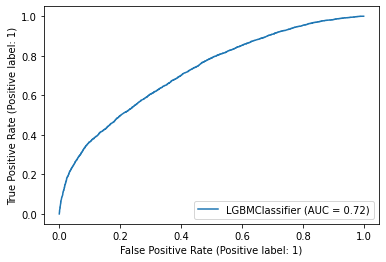

In [25]:
plot_roc_curve(gbm, X_test, y_test)  

Best Threshold=0.299602, G-Mean=0.652


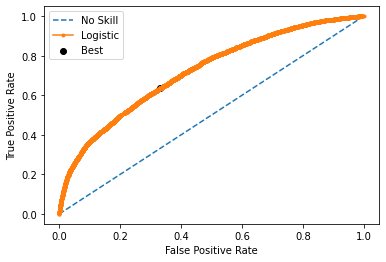

In [26]:
from matplotlib import pyplot
y_pred = gbm.predict_proba(X_test)[:, 1]
# keep probabilities for the positive outcome only
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()